In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from scipy.integrate import solve_ivp
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import pandas as pd 
from scipy.signal import welch

np.random.seed(5284)

In [14]:
# if graphs dont run correctly
%matplotlib inline

## Problem 1
**1.1**
We will implement a discrete-event SIR model based on Gillespie's Direct Algorithm (GA), to analyze how stochasticity influences SIR dynamics. We will do this by comparing the mean results of multiple stochastic simulations with the deterministic solution obtained from an equivalent ODEs model, solved using `solve_ivp`.

In [15]:
# Stochastic implementation
def SIR_stochastic(x0, y0, z0, beta, gamma, mu, t_stop):
    time, X, Y, Z = 0.0, x0, y0, z0
    times, X_updates, Y_updates, Z_updates = [time], [X], [Y], [Z]

    while time < t_stop:
        N = X+Y+Z
        if N <= 0:
            break
        rate_birth = mu*N
        rate_trans = beta * X * Y / N
        rate_rec = gamma * Y
        rate_deathX = mu*X
        rate_deathY = mu*Y
        rate_deathZ = mu*Z
        r_tot = rate_birth + rate_trans + rate_rec + rate_deathX + rate_deathY  + rate_deathZ
        if r_tot <= 0:
            break
        rand1, rand2 = np.random.uniform(0,1), np.random.uniform(0,1) 
        P = rand2 * r_tot
        dt = -np.log(rand1) / r_tot
        time += dt

        if P < rate_birth: # event 1: birth
            X += 1
        elif P < (rate_birth + rate_trans): # 2: transimission
            X -= 1
            Y += 1
        elif P < (rate_birth + rate_trans + rate_rec): # 3: recovery
            Y -= 1
            Z += 1
        elif P < (rate_birth + rate_trans + rate_rec + rate_deathX): # 4: death in X
            X -= 1
        elif P < (rate_birth + rate_trans + rate_rec + rate_deathX + rate_deathY): # 5: death in Y
            Y -= 1
        elif P < r_tot: # 6: death in Z
            Z -= 1

        X_updates.append(X)
        Y_updates.append(Y)
        Z_updates.append(Z)
        times.append(time)
    return [np.array(times), np.array(X_updates), np.array(Y_updates), np.array(Z_updates)]

In [16]:
# Deterministic Implementation
def SIR_demo(t, i0, beta, gamma, mu): # where mu = death rate = birth rate
    X, Y, Z = i0[0], i0[1], i0[2]
    N = X + Y + Z
    dXdt = mu*N - beta * X * Y/N - mu*X
    dYdt = beta * X * Y/N - (gamma+mu)*Y
    dZdt = gamma * Y - mu * Z
    return [dXdt, dYdt, dZdt]

def SIR_demo_solve(i0, beta, gamma, mu, T = 400, steps = 1000):
    t_span = (0, T)
    t_eval = np.linspace(0, T, steps)  
    sol = solve_ivp(SIR_demo, t_span, i0, t_eval = t_eval, args=(beta, gamma, mu))
    return sol.t, sol.y[0], sol.y[1], sol.y[2]

We visualize a first deterministic vs stochastic implementation.

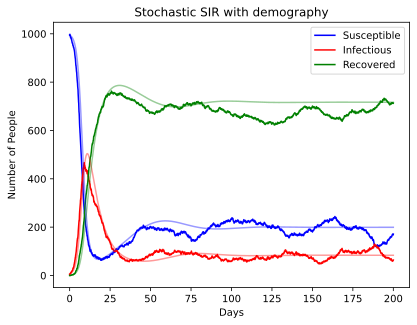

In [17]:
# just for visualization: deterministic vs stochastic
x0_init, y0_init, z0_init = 995, 5, 0
N_init = x0_init + y0_init + z0_init
beta_init = 0.8
gamma_init = 1/7
mu_init  = 1/60
t_stop = 200
stoch_dynamics = SIR_stochastic(x0_init, y0_init, z0_init, beta_init, gamma_init, mu_init, t_stop)
det_dynamics = SIR_demo_solve((x0_init, y0_init, z0_init), beta_init, gamma_init, mu_init, t_stop)

plt.plot(stoch_dynamics[0], stoch_dynamics[1], c="b", label="Susceptible")
plt.plot(stoch_dynamics[0], stoch_dynamics[2], c="r", label="Infectious")
plt.plot(stoch_dynamics[0], stoch_dynamics[3], c="g", label="Recovered")
plt.plot(det_dynamics[0], det_dynamics[1], c="b", alpha = 0.4)
plt.plot(det_dynamics[0], det_dynamics[2], c="r", alpha = 0.4)
plt.plot(det_dynamics[0], det_dynamics[3], c="g", alpha = 0.4)
plt.legend()
plt.xlabel("Days")
plt.ylabel("Number of People")
plt.title("Stochastic SIR with demography")
plt.show()

We introduce the tau-leap version of the GA algorithm, which allows to adjust the noise level by controlling the time step, $\tau$

In [18]:
# GA Tau-leap
def SIR_tau(x0, y0, z0, beta, gamma, mu, t_stop, tau):
    t, X, Y, Z = 0.0, x0, y0, z0
    times, Xs, Ys, Zs = [t], [X], [Y], [Z]

    while t < t_stop: 
        N = X + Y + Z 
        if N <= 0:
            break
        rate_birth = mu*N
        rate_trans = beta * X * Y / N
        rate_rec = gamma * Y
        rate_deathX = mu*X
        rate_deathY = mu*Y
        rate_deathZ = mu*Z
        rates = np.array([rate_birth, rate_trans, rate_rec, rate_deathX, rate_deathY, rate_deathZ])
        events = np.random.poisson(lam=np.maximum(rates*tau, 0)) # expected num of events in tau
        X += events[0] - events[1] - events[3]
        Y += events[1] - events[2] - events[4]
        Z += events[2] - events[5]

        t += tau 
        times.append(t)
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
    return np.array(times), np.array(Xs), np.array(Ys), np.array(Zs)

We show how the tau-leap stochastic method compares with the deterministic behaviour of SIR dynamics for different $\tau$. As the parameter increases, dynamics get smoother and closer to the deterministc ones.

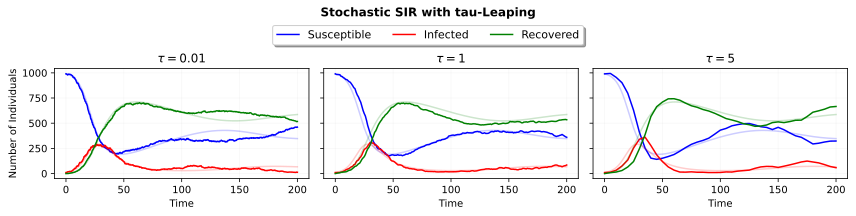

In [19]:
x0_tau, y0_tau, z0_tau = 990, 10, 0
beta_tau, gamma_tau, mu_tau = 0.3, 0.1, 0.01
taus = [0.01, 1, 5]
det_dynamics_tau = SIR_demo_solve((x0_tau, y0_tau, z0_tau),
                                  beta_tau, gamma_tau, mu_tau, t_stop)
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i, tau in enumerate(taus):
    ax = axes[i]
    times, X, Y, Z = SIR_tau(x0_tau, y0_tau, z0_tau,
                             beta_tau, gamma_tau, mu_tau, t_stop, tau)
    # Stochastic trajectories
    ax.plot(times, X, c='b', label="Susceptible")
    ax.plot(times, Y, c='r', label="Infected")
    ax.plot(times, Z, c='g', label="Recovered")
    # Deterministic reference (faded)
    ax.plot(det_dynamics_tau[0], det_dynamics_tau[1], c='b', alpha=0.2)
    ax.plot(det_dynamics_tau[0], det_dynamics_tau[2], c='r', alpha=0.2)
    ax.plot(det_dynamics_tau[0], det_dynamics_tau[3], c='g', alpha=0.2)

    ax.set_title(f"$\\tau = {tau}$")
    ax.set_xlabel("Time")
    ax.grid(alpha=0.1)
    if i == 0:
        ax.set_ylabel("Number of Individuals")
        
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=3, fontsize=11, shadow=True)
fig.suptitle("Stochastic SIR with tau-Leaping", fontweight="bold", y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**1.2** We now investigate how varying the model parameters changes the behaviour of the stochastic dynamics, with a particular focus on the five hallmarks of stochasticity.

In [20]:
x0_frac, y0_frac, z0_frac = 0.9, 0.1, 0.0
N_values = [500, 1000, 5000] # changing population size
R0_values = [1.8, 4.3, 11]  # changing infectivity 
gamma = 1/7
mu = 1/60
t_stop = 200 
num_runs = 5 # number of stochastic simulations
time_grid = np.linspace(0, t_stop, 200)
# dictionaries to store values
dict_varX = {} 
dict_varY = {} 
dict_covXY ={}
dict_allY = {}
dict_allX = {}
dict_Y_det ={}
dict_X_det = {}
cv_results = {R0: [] for R0 in R0_values}
max_dev_results = {R0: [] for R0 in R0_values}

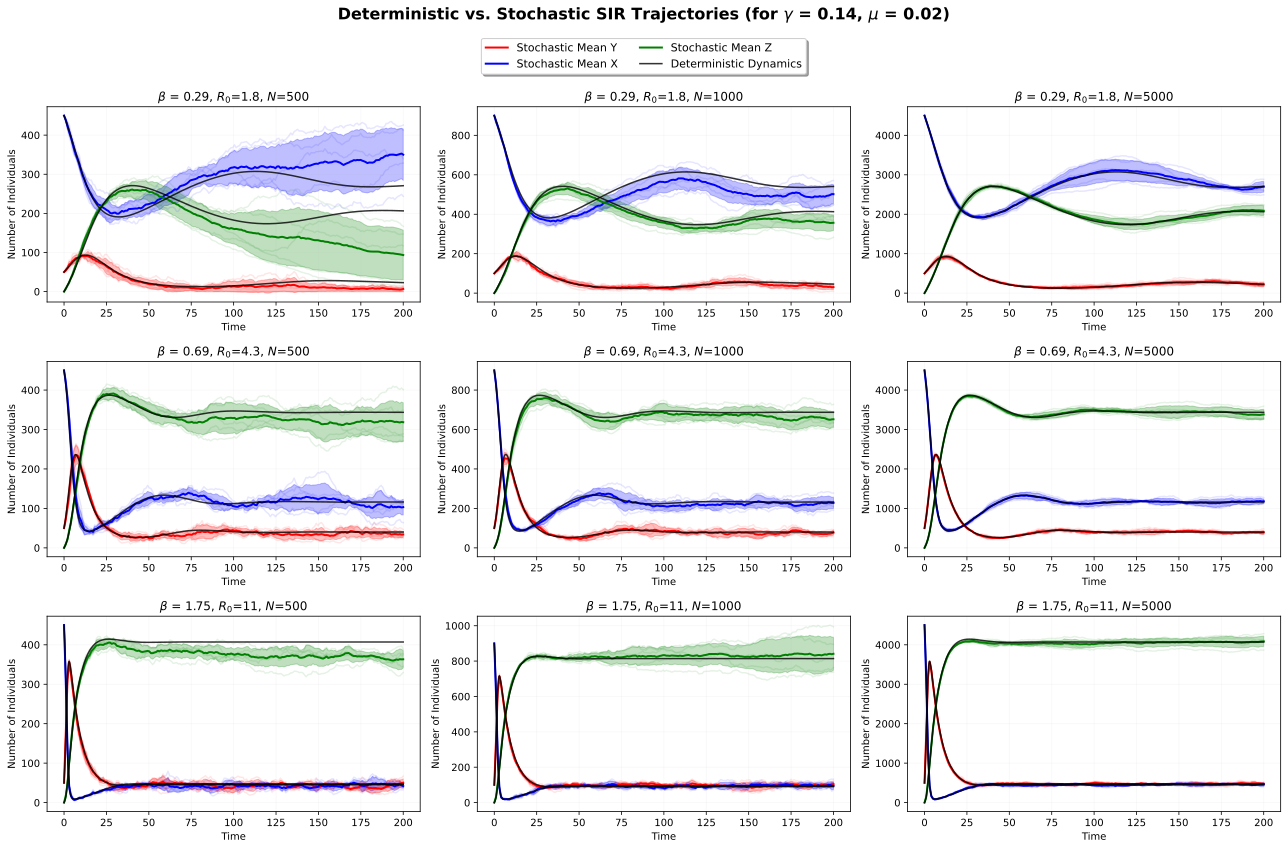

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, R0 in enumerate(R0_values): 
    beta = R0 * (gamma + mu)
    for j, N in enumerate(N_values):
        I_star = mu * (R0 - 1) / beta
        S_star = 1 / R0
        x0, y0, z0 = x0_frac*N, y0_frac*N, 0

        all_X, all_Y, all_Z= np.zeros((num_runs, len(time_grid))), np.zeros((num_runs, len(time_grid))), np.zeros((num_runs, len(time_grid)))
        max_devs = []
        for run in range(num_runs): 
            times, X, Y, Z = SIR_stochastic(x0, y0, z0, beta, gamma, mu, t_stop)
            # first plot
            all_X[run] = np.interp(time_grid, times, X)
            all_Y[run] = np.interp(time_grid, times, Y)
            all_Z[run] = np.interp(time_grid, times, Z)
            axes[i,j].plot(time_grid, all_Y[run], color='red', alpha = 0.1)
            axes[i,j].plot(time_grid, all_X[run], color = "blue", alpha = 0.1)
            axes[i,j].plot(time_grid, all_Z[run], color = "green", alpha = 0.1)

            # deviation (normalized) from equilibrium (for this single run)
            mask = time_grid >= 25
            max_dev = np.max(np.abs(all_Y[run][mask] / N - I_star)/I_star)
            max_devs.append(max_dev)
        
        # store mean max_dev for the (R0, N) combination
        max_dev_results[R0].append(np.mean(max_devs))
        
        all_X = np.array(all_X)
        all_Y = np.array(all_Y)
        all_Z = np.array(all_Z)
        dict_allY[(R0, N)] = all_Y
        dict_allX[(R0, N)] = all_X

        # calculate statistics
        mean_X, mean_Y,  mean_Z = all_X.mean(axis=0), all_Y.mean(axis=0), all_Z.mean(axis=0)
        var_X, var_Y, var_Z = all_X.var(axis=0), all_Y.var(axis=0), all_Z.var(axis=0)
        cov_XY = np.mean((all_X - mean_X) * (all_Y - mean_Y), axis=0)

        dict_varX[(R0, N)] = var_X
        dict_varY[(R0, N)] = var_Y
        dict_covXY[(R0, N)] = cov_XY

        mean_var_X = var_X.mean()
        mean_var_Y = var_Y.mean()
        mean_cov_XY = cov_XY.mean()
        mean_Y_scalar = np.mean(mean_Y)
        std_Y_scalar = np.mean(all_Y.std(axis=0))
        cv = std_Y_scalar / mean_Y_scalar if mean_Y_scalar > 0 else 0
        cv_results[R0].append(cv)

        # compare with deterministic dynamics
        t_det, X_det, Y_det, Z_det = SIR_demo_solve((x0, y0, z0), beta, gamma, mu, T=200)
        dict_Y_det[(R0, N)] = Y_det
        dict_X_det[(R0, N)] = X_det

        ax = axes[i, j]
        ax.fill_between(time_grid, mean_Y - np.sqrt(var_Y), mean_Y + np.sqrt(var_Y), 
                               alpha=0.25, color='r')
        ax.fill_between(time_grid, mean_X - np.sqrt(var_X), mean_X + np.sqrt(var_X), 
                               alpha=0.25, color='b')
        ax.fill_between(time_grid, mean_Z - np.sqrt(var_Z), mean_Z + np.sqrt(var_Z), 
                               alpha=0.25, color='g')
        ax.plot(time_grid, mean_Y, c='r', lw=2, label = "Stochastic Mean Y")
        ax.plot(time_grid, mean_X, c='b', lw=2, label = "Stochastic Mean X")
        ax.plot(time_grid, mean_Z, c='g', lw=2, label = "Stochastic Mean Z")
        ax.plot(t_det, X_det, c='black', alpha=0.8, label = "Deterministic Dynamics")
        ax.plot(t_det, Y_det, c='black', alpha=0.8)
        ax.plot(t_det, Z_det, c='black', alpha=0.8)
        ax.set_title(f"$\\beta$ = {beta:.2f}, $R_0$={R0}, $N$={N}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Individuals")
        ax.grid(alpha=0.1)

handles, labels = axes.flat[-1].get_legend_handles_labels()
plt.suptitle(f"Deterministic vs. Stochastic SIR Trajectories (for $\\gamma$ = {gamma:.2f}, $\\mu$ = {mu:.2f})", fontsize=16, y=0.98, fontweight= "bold")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=11, shadow=True)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

**1.3** We investigate how varying the model parameteres ($N$ and $R_0$) changes the stochastic dynamics, and in particular, we investigate the changes that happen to the variance of the infected class (Y) and covariance between X (susceptible class) and Y. 

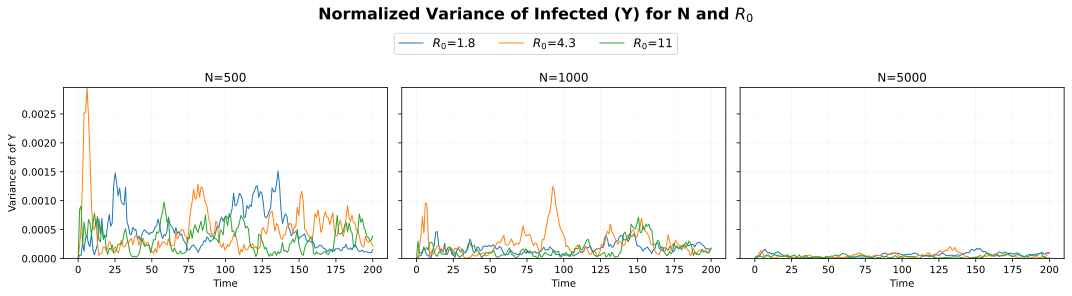

In [22]:
# normalized Variance of Y for three values of N and Ro
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True) 
max_var = 0  

for N in N_values:
    for R0 in R0_values:
        var_Y = dict_varY[(R0, N)]
        var_Y_percapita = var_Y / N**2
        max_var = max(max_var, np.max(var_Y_percapita))

for j, N in enumerate(N_values):
    ax = axes[j]
    for i, R0 in enumerate(R0_values):
        var_Y = dict_varY[(R0, N)]
        var_Y_percapita = var_Y / N**2
        ax.plot(time_grid, var_Y_percapita, lw=1, label=f"$R_0$={R0}")  
    ax.set_xlabel("Time")
    if j == 0:
        ax.set_ylabel("Variance of of Y")
    ax.set_title(f"N={N}")
    ax.grid(alpha=0.1)
    ax.set_ylim(0, max_var)  

handles, labels = axes.flat[-1].get_legend_handles_labels()
plt.suptitle("Normalized Variance of Infected (Y) for N and $R_0$", fontsize=16, y=1.02, fontweight = "bold")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(R0_values), fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

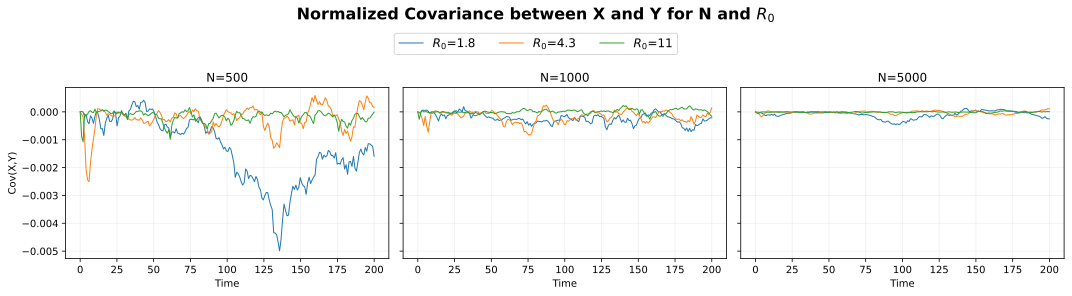

In [23]:
# normalized negative covariance
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)  
for j, N in enumerate(N_values):
    ax = axes[j]
    for i, R0 in enumerate(R0_values):
        cov_XY = dict_covXY[(R0, N)]
        cov_XY_percapita = cov_XY / N**2  
        ax.plot(time_grid, cov_XY_percapita, lw=1, label=f'$R_0$={R0}')
    
    ax.set_xlabel('Time')
    if j == 0:
        ax.set_ylabel('Cov(X,Y)')
    ax.set_title(f'N={N}')
    ax.grid(alpha=0.2)

handles, labels = axes.flat[-1].get_legend_handles_labels()
plt.suptitle("Normalized Covariance between X and Y for N and $R_0$", fontsize=16, y=1.02, fontweight = "bold")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(R0_values), fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

**1.4** Stochastic dynamics show considerable fluctuations around the fixed point. The introduction of noise amplifies intrinsic oscillations (resonance), causing them to exceed deterministic amplitudes and temporarily leave the fixed points. Conversely, transient-like returns demonstrate that even when a trajectory deviates significantly from the stable equilibrium, the strong underlying deterministic dynamics pull it quickly back.

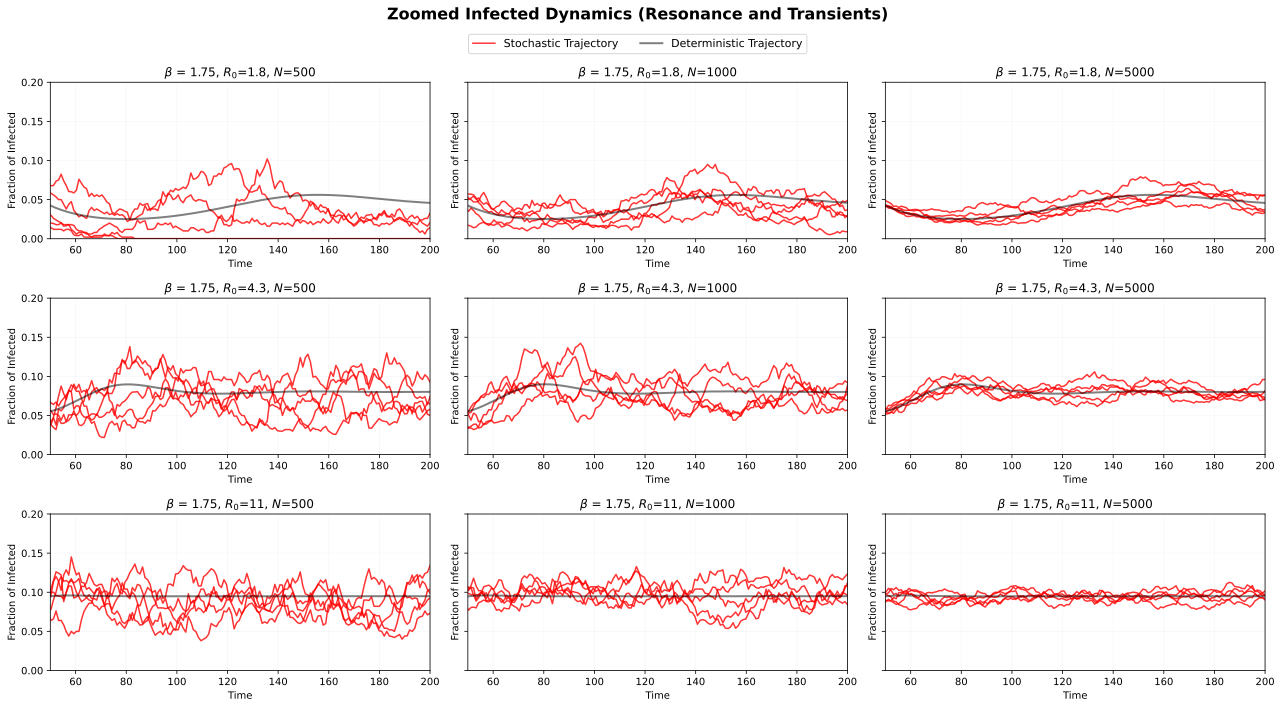

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10), sharey = True)

for i, R0 in enumerate(R0_values):
    for j, N in enumerate(N_values):
        # Retrieve data
        Ys = dict_allY[(R0, N)]
        Ys_det = dict_Y_det[(R0, N)]
        ax = axes[i, j]
        for r in range(Ys.shape[0]):
            ax.plot(time_grid, Ys[r]/N, color='red', alpha=0.8, label = ('Stochastic Trajectory' if r == 0 else None))
        ax.plot(t_det, Ys_det/N, c='black', lw=2, alpha=0.5, label='Deterministic Trajectory')
        ax.set_xlim(50,200)
        ax.set_ylim(0,0.2)
        ax.set_title(f"$\\beta$ = {beta:.2f}, $R_0$={R0}, $N$={N}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Fraction of Infected")
        ax.grid(alpha=0.1)

handles, labels = axes.flat[-1].get_legend_handles_labels()
plt.suptitle("Zoomed Infected Dynamics (Resonance and Transients)", fontsize=16, y=0.98, fontweight = "bold")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("zoomed_infected.png")

/Users/juliarotko/miniconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  warnings.warn('nperseg = {0:d} is greater than input length '


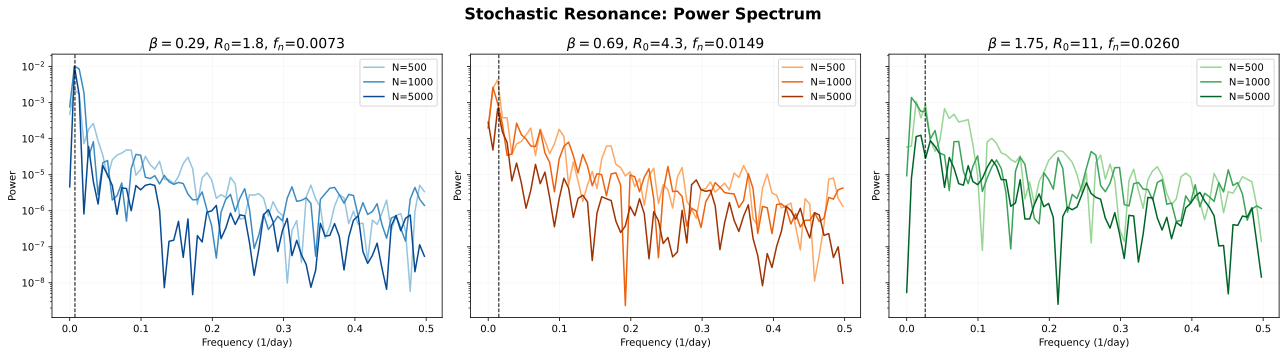

In [25]:
# PSD Analysis
dict_freq = {}
for i, R0 in enumerate(R0_values): 
    for j, N in enumerate(N_values):
        A = 1 / (mu*(R0 - 1))
        G = 1/(mu + gamma)
        dict_freq[(R0, N)] = 1/(2*np.pi * np.sqrt(A*G))
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
t_start = 50
start_index = np.where(time_grid >= t_start)[0][0]
dt = time_grid[1] - time_grid[0]

base_cmaps = {
    R0_values[0]: cm.Blues,
    R0_values[1]: cm.Oranges,
    R0_values[2]: cm.Greens
}

for i, R0 in enumerate(R0_values):
    beta = R0*(gamma + mu)
    ax = axes[i]
    f_theoretical = dict_freq[(R0, N_values[0])]
    cmap = base_cmaps[R0]
    shades = np.linspace(0.4, 0.9, len(N_values)) 
    for j, (N, shade) in enumerate(zip(N_values, shades)):
        key = (R0, N)
        I_all_runs_sliced = dict_allY[key][:, start_index:] / N
        I_timeseries = np.mean(I_all_runs_sliced, axis=0)
        freqs, psd = welch(I_timeseries, fs=1/dt) 
        ax.semilogy(freqs, psd, color=cmap(shade), label=f"N={N}")
    ax.legend()
    ax.axvline(f_theoretical, color='k', linestyle='--', linewidth=1, label='$f_n$')
    ax.set_title(f"$\\beta = {beta:.2f}$, $R_0$={R0}, $f_n$={f_theoretical:.4f}", size = 14)
    ax.set_xlabel('Frequency (1/day)')
    ax.set_ylabel("Power")
    ax.grid(alpha=0.1)

fig.suptitle("Stochastic Resonance: Power Spectrum", fontsize=16, fontweight = "bold")
plt.tight_layout(rect=[0, 0, 1, 1])
fig.savefig("stochastic_resonance.png")
plt.show()


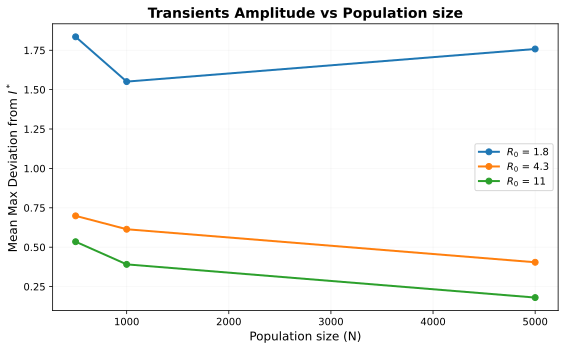

In [26]:
# Plot max transients vs N for different R0
plt.figure(figsize=(8, 5))
for R0 in R0_values:
    plt.plot(N_values, max_dev_results[R0], marker='o', lw=2, label=f'$R_0$ = {R0}')
plt.xlabel("Population size (N)", fontsize=12)
plt.ylabel("Mean Max Deviation from $I^*$", fontsize=12)
plt.title("Transients Amplitude vs Population size", fontsize=14, fontweight = "bold")
plt.legend()
plt.grid(alpha=0.1)
plt.tight_layout()
plt.show()

**1.4** Finally, stohcasticity implies a higher possibility of extinction of the virus in a closed populations, even when $R_0 > 1$. We will investigate the interaction between $R_0$ and $N$ and their impact the extinction process.

In [27]:
t_stop = 365 
n_reps = 30 
gamma = 1/7 
mu = 1/60 
R0_list = [1.8, 3.2, 8] 
N_list = np.linspace(100, 2500, 20, dtype=int) 
extinctions_number = {R0: [] for R0 in R0_list} # count extinctions
for R0 in R0_list: 
    beta = R0 * (gamma + mu) 
    for N in N_list: 
        x0, y0, z0 = 0.9*N, 0.1*N, 0 
        extinctions = 0 
        for r in range(n_reps): 
            # using tau-leap for efficiency
            t, X, Y, Z = SIR_tau(x0, y0, z0, beta, gamma, mu, t_stop, tau=0.1) 
            ext_indices = np.where(Y < 1)[0]
            if len(ext_indices) > 0: # update extinction
                extinctions += 1
        extinctions_number[R0].append(extinctions) 
    print(f"Completed R0 = {R0}") 

Completed R0 = 1.8
Completed R0 = 3.2
Completed R0 = 8


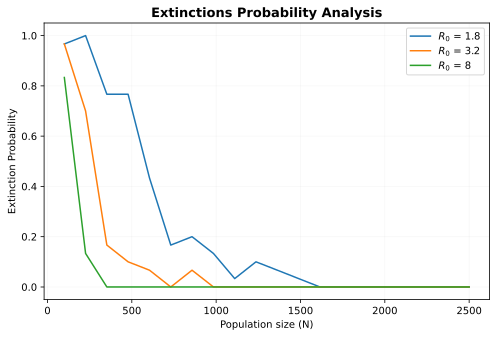

In [28]:
plt.figure(figsize=(8, 5))
for R0 in R0_list:
    prob = np.array(extinctions_number[R0]) / n_reps 
    plt.plot(N_list, prob, label=f'$R_0$ = {R0}') 
plt.xlabel("Population size (N)") 
plt.ylabel("Extinction Probability") 
plt.legend() 
plt.grid(alpha=0.1) 
plt.title("Extinctions Probability Analysis", fontsize=13, fontweight = "bold")
plt.show()

We then estimate the Critical Community Size (CCS) by finding the population size $N$ for which the total number of observed extinctions drops to one, via interpolation.

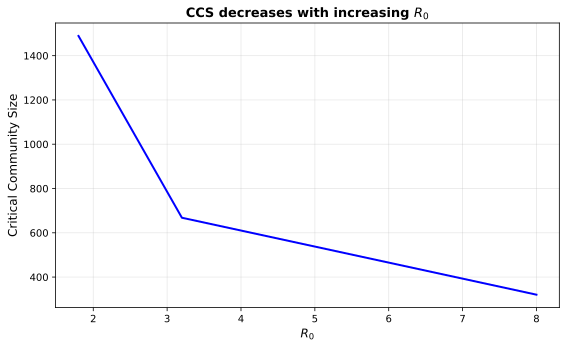

In [29]:
extinction_thr = 1
ccs_values = []
for R0 in R0_list:
    n_ext = extinctions_number[R0] 
    crosses_threshold = np.any(np.array(n_ext) < extinction_thr) 
    if crosses_threshold:
        ccs = np.interp(extinction_thr, n_ext[::-1], N_list[::-1])
        ccs_values.append(ccs)
    else:
        ccs_values.append(np.nan) 
plt.figure(figsize=(8, 5))
valid_ccs = [(R0, ccs) for R0, ccs in zip(R0_list, ccs_values) if not np.isnan(ccs)]
if valid_ccs:
    R0_valid, ccs_valid = zip(*valid_ccs)
    plt.plot(R0_valid, ccs_valid, lw=2, c= "b")
    plt.xlabel('$R_0$', fontsize=12)
    plt.ylabel('Critical Community Size', fontsize=12)
    plt.title('CCS decreases with increasing $R_0$', fontsize=13, fontweight = "bold")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Problem 2
**2.1**
We will implement an SIR model for disease spread on different types of networks (Barabasi-Albert, Watts-Strogatz, Erdos-Reyni), accounting for their adjustable parameters and intrinisc characteristics.

In [30]:
def SIR_network_simulate(beta, gamma, graph, i0 = 0.1, initial_infected_nodes = None, time_steps=200, simulations=10): 
    num_compartments = 3
    results = np.zeros((simulations, time_steps, num_compartments))

    for s in range(simulations):
        model = ep.SIRModel(graph)
        # Configure the model
        config = mc.Configuration()
        config.add_model_parameter("beta", beta)
        config.add_model_parameter("gamma", gamma)
        # Consider initial infection...
        if initial_infected_nodes is not None: # infect specific nodes
            config.add_model_initial_configuration("Infected", initial_infected_nodes)
        else: # infect i0*Nodes randomly
            config.add_model_parameter("fraction_infected", i0)
        model.set_initial_status(config)
        # Run simulation
        iterations = model.iteration_bunch(time_steps)
        for i, iter in enumerate(iterations):
            for compartment, node_count in iter["node_count"].items():
                results[s, i, compartment] = node_count
    return results

**2.2** We will now consider multiple model networks with their own parameters and we will measure interesting statistics for analysing spreading on the network, like centrality measures, clustering coefficient, degree variance and average path length.

In [31]:
# later used for plotting and simulations
def generate_networks(N, k_avg = 6, seed = 5284):
    p_er = k_avg / (N - 1) 
    k_ws = k_avg
    p_ws = 0.3 
    m_ba = k_avg // 2
    G_er = nx.erdos_renyi_graph(N, p_er, seed=seed)
    G_ws = nx.watts_strogatz_graph(N, k_ws, p_ws, seed=seed)
    G_ba = nx.barabasi_albert_graph(N, m_ba, seed=seed)
    graphs = [
    ("erdos_renyi", G_er),
    ("watts_strogatz", G_ws),
    ("barabasi_albert", G_ba)
    ]
    return graphs

In [32]:
# Evaluate different networks (of equivalent form)
def network_stats(G):
    # spreading potential
    degrees_arr = np.array([d for key, d in G.degree()])
    avg_degree = degrees_arr.mean() / (G.number_of_nodes() - 1)
    degree_centrality = nx.degree_centrality(G)
    avg_degree_centrality = np.mean(list(degree_centrality.values()))
    # heterogeneity and hubs
    std_degree = np.sqrt(degrees_arr.var())
    # local structure
    clustering = nx.average_clustering(G)
    # global spread speed
    path_length = nx.average_shortest_path_length(G) if (G.number_of_nodes() <= 5000 and nx.is_connected(G)) else np.nan
    # brokers
    if G.number_of_nodes() <= 5000:
        betweenness_centrality = nx.betweenness_centrality(G) 
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
    else:
        avg_betweenness_centrality = np.nan
    stats = {
        "Average Degree": avg_degree,
        "Average Degree Centrality": avg_degree_centrality,
        "Degree Standard Deviation": std_degree,
        "Clustering Coefficient": clustering,
        "Average Path Length": path_length,
        "Degree Distribution": degrees_arr,
        "Average Betweenness Centrality": avg_betweenness_centrality
     }
    return stats

In [33]:
# Set parameters for networks
n_trials = 10 # reduce for faster code, but no/less variability
N_stats = 500
results_networks = []
tit_col = {
    'erdos_renyi': ("Erdos-Renyi", "#1f77b4"),     
    'watts_strogatz': ("Watts-Strogatz", "#ff7f0e"),
    'barabasi_albert':  ("Barabasi-Albert", "#2ca02c")
}

In [34]:
def generate_network_data(N, n_trials, network_type, param_values, param_name, results_list, **kwargs):
    for param_value in param_values:
        for trial in range(n_trials):
            if network_type == "erdos_renyi":
                G = nx.erdos_renyi_graph(N, param_value, seed=trial+np.random.randint(0,100))
            elif network_type == "barabasi_albert":
                G = nx.barabasi_albert_graph(N, param_value, seed=trial+np.random.randint(0,100))
            elif network_type == "watts_strogatz":
                G = nx.watts_strogatz_graph(N, kwargs['k'], param_value, seed=trial+np.random.randint(0,100))
            # Compute statistics and update dictionary
            stats = network_stats(G)
            stats["network_type"] = network_type
            stats["N"] = N
            stats["param_varied"] = param_name
            stats["param_value"] = param_value
            stats["trial"] = trial
            
            results_list.append(stats)

In [35]:
# Erdos-Renyi
p_values = [0.01, 0.05, 0.1, 0.2]
generate_network_data(N_stats, n_trials, "erdos_renyi", p_values, "p", results_networks)

# Watts-Strogatz
k_ws = 6
p_values_ws = [0.1, 0.3, 0.5, 0.8]
generate_network_data(N_stats, n_trials, "watts_strogatz", p_values_ws, "p_rewiring", results_networks, k=k_ws)

# Barabasi-Albert
m_values = [2, 5, 8, 10]
generate_network_data(N_stats, n_trials, "barabasi_albert", m_values, "m", results_networks)

In [36]:
# results to data frame
df = pd.DataFrame(results_networks)
df.head()

Average Degree  Average Degree Centrality  Degree Standard Deviation  \
0        0.010188                   0.010188                   2.213808   
1        0.009820                   0.009820                   2.334524   
2        0.009948                   0.009948                   2.325232   
3        0.009996                   0.009996                   2.137254   
4        0.010365                   0.010365                   2.344017   

   Clustering Coefficient  Average Path Length  \
0                0.006905             4.012745   
1                0.006777                  NaN   
2                0.010351                  NaN   
3                0.004773                  NaN   
4                0.010219                  NaN   

                                 Degree Distribution  \
0  [3, 4, 6, 9, 4, 6, 1, 3, 8, 8, 5, 9, 6, 5, 9, ...   
1  [2, 4, 6, 8, 3, 2, 1, 2, 3, 7, 4, 8, 5, 5, 6, ...   
2  [7, 8, 7, 2, 5, 5, 8, 6, 1, 4, 9, 7, 6, 4, 7, ...   
3  [4, 9, 2, 1, 8, 5, 2, 4, 5, 6, 3, 4, 7, 2, 4, ...   
4  [3, 3, 4, 5, 5, 2, 10, 3, 4, 6, 4, 5, 5, 5, 9,...   

   Average Betweenness Centrality network_type    N param_varied  param_value  \
0                        0.006050  erdos_renyi  500            p         0.01   
1                        0.006033  erdos_renyi  500            p         0.01   
2                        0.005912  erdos_renyi  500            p         0.01   
3                        0.005875  erdos_renyi  500            p         0.01   
4                        0.005764  erdos_renyi  500            p         0.01   

   trial  
0      0  
1      1  
2      2  
3      3  
4      4

In [37]:
metrics = ['Average Degree Centrality','Degree Standard Deviation', 'Clustering Coefficient','Average Path Length', 'Average Betweenness Centrality']
df_param = df[df['param_varied'] != 'N']
network_types = df_param['network_type'].unique()

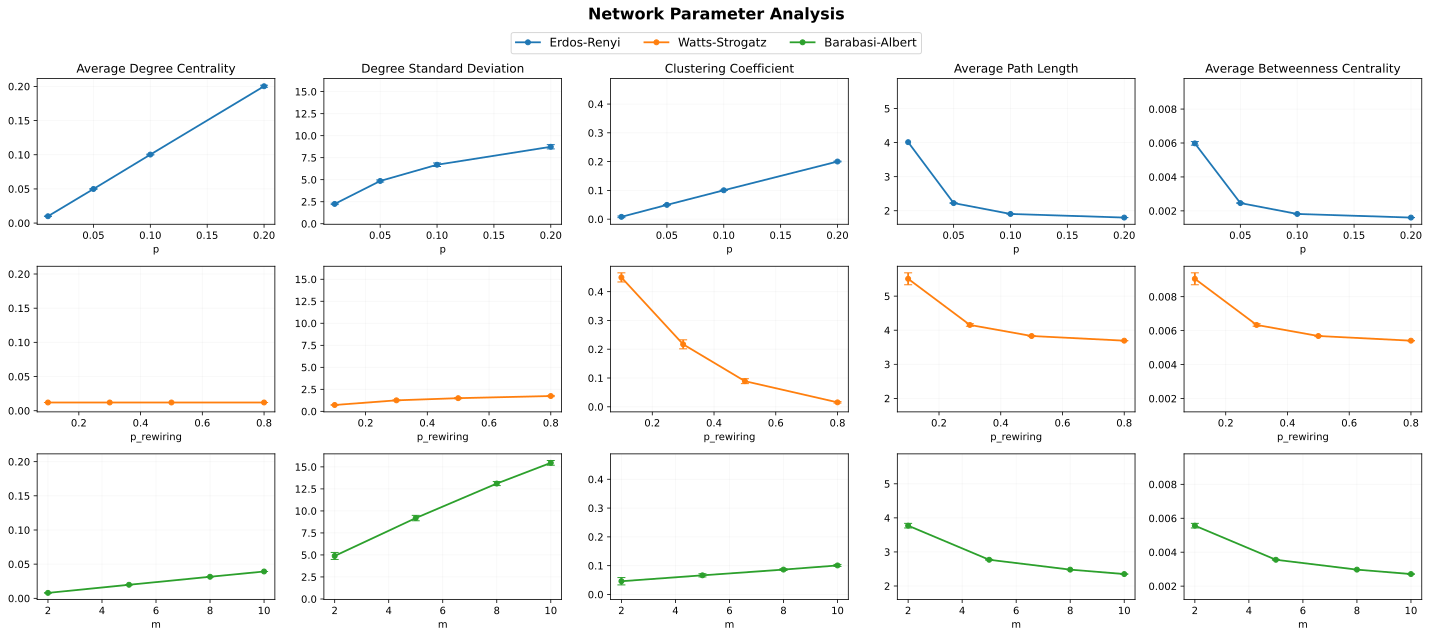

In [38]:
fig, axes = plt.subplots(len(network_types), len(metrics), figsize=(20, 9), sharex=False, sharey="col")
fig.subplots_adjust(hspace=0.35, wspace=0.3)

for row_idx, network_type in enumerate(network_types):
    data = df_param[df_param['network_type'] == network_type]
    param_name = data['param_varied'].iloc[0]
    grouped = data.groupby('param_value')[metrics].agg(['mean', 'std']).reset_index()
    tit, col = tit_col[network_type][0], tit_col[network_type][1]
    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx] if len(network_types) > 1 else axes[col_idx]
        x = grouped['param_value']
        y_mean = grouped[(metric, 'mean')]
        y_std = grouped[(metric, 'std')]
        ax.errorbar(
            x, y_mean, yerr=y_std,
            marker='o', markersize=5, capsize=4,
            color=col, label=tit,
            linewidth=1.8
        ) 
        ax.set_xlabel(param_name)
        if row_idx == 0:
            ax.set_title(metric)

        ax.grid(alpha=0.1)

fig.suptitle(f'Network Parameter Analysis', y = 0.98, fontweight ="bold", size = 16)
handles = [plt.Line2D([], [], color=col, marker='o', markersize=5, label=tit, linewidth=1.8)
           for tit, col in [tit_col[nt] for nt in network_types]]
fig.legend(handles=handles, loc='upper center', ncols = 3, bbox_to_anchor=(0.5, 0.95), fontsize = 12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

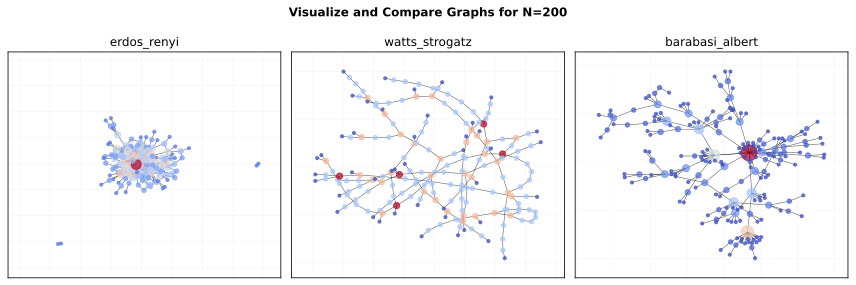

In [39]:
# Just for visualization purposes - plot network structure
N_plot = 200 
seed_plot = 5284 

# Generate different networks for k_avg around 3
graphs = generate_networks(N_plot, k_avg = 3, seed = seed_plot)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(f"Visualize and Compare Graphs for N={N_plot}", fontweight='bold')

for i, (network_type, G) in enumerate(graphs):
    ax = axes[i]
    # nodes will be colored/sized according to degree
    degrees = dict(G.degree())
    node_size = [v * 10 for v in degrees.values()] 
    pos = nx.spring_layout(G, seed=seed_plot) 
    nx.draw_networkx(
        G,
        pos,
        ax=ax,
        node_size=node_size,
        node_color=list(degrees.values()),
        cmap=plt.cm.coolwarm,
        with_labels = False,
        width=0.5,
        alpha=0.7 
    )
    ax.set_title(network_type)
    ax.grid(alpha = 0.1)

plt.tight_layout() 
plt.show()

**2.3** We simulate epidemic spreading on the networks and vary the fraction of initial infected $i_0$, which nodes are initially infected (highest degree, betweenness or closeness centrality) and the infectious rate. This will allow us to compare and discuss how the disease spreads in the different networks under different conditions.

In [40]:
#  set parameters for network simulation and generate networks
beta_sim = 0.2
gamma_sim = 1/7
N_sim = 1000
graphs_sim = generate_networks(N_sim)

In [41]:
# 1. Change i0 values
i0_values = np.linspace(0.01, 0.2, 10)
i0_results = {}
for network_type, G in graphs_sim:
    results_for_graph = []
    print(f"Running i0 variation for {network_type}...")
    for i0 in i0_values:
        sim_results = SIR_network_simulate(graph=G, beta = beta_sim, gamma = gamma_sim, i0=i0, time_steps=200,simulations=10)
        mean_result = sim_results.mean(axis=0) 
        results_for_graph.append(mean_result)
    i0_results[network_type] = results_for_graph

Running i0 variation for erdos_renyi...
Running i0 variation for watts_strogatz...
Running i0 variation for barabasi_albert...


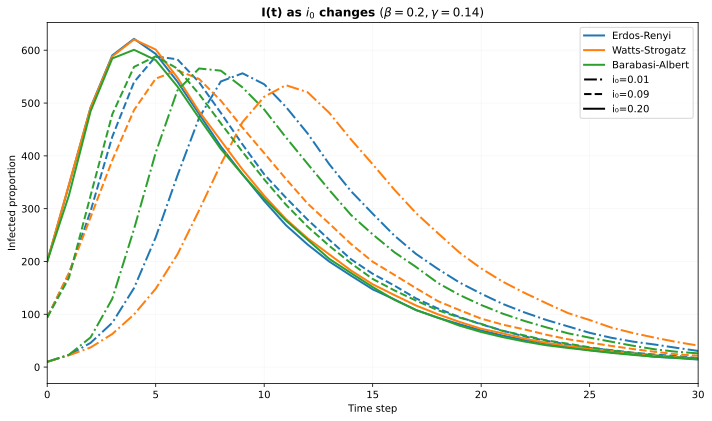

In [42]:
# plot 3 examples of above simulation (just for visualization)
selected_indices = [0, 4, 9] 
selected_i0_values = [i0_values[i] for i in selected_indices]
line_styles = ['-.', '--', '-']  
plt.figure(figsize=(10, 6))

for network_type, results_for_graph in i0_results.items():
    tit, col = tit_col[network_type][0], tit_col[network_type][1]
    for ls, i0, mean_result in zip(line_styles, selected_i0_values, [results_for_graph[i] for i in selected_indices]):
        plt.plot(
            mean_result[:, 1],
            linestyle=ls,
            color=col,
            lw=2,
            label=f"{tit}, i₀={i0:.2f}"
        )
network_handles = [plt.Line2D([], [], color=col, lw=2, label=tit)
                   for nt in network_types for tit, col in [tit_col[nt]]]

i0_handles = [plt.Line2D([], [], color='k', lw=2, linestyle=ls, label=f"i₀={val:.2f}") 
              for ls, val in zip(line_styles, selected_i0_values)]
plt.xlim(0, 30)
plt.xlabel("Time step")
plt.ylabel("Infected proportion")
plt.grid(alpha=0.1)
plt.title(f'I(t) as $i_0$ changes $(\\beta={beta_sim}, \\gamma={gamma_sim:.2f})$', fontweight='bold')
plt.legend(handles=network_handles + i0_handles, loc='upper right')
plt.tight_layout()
plt.show()


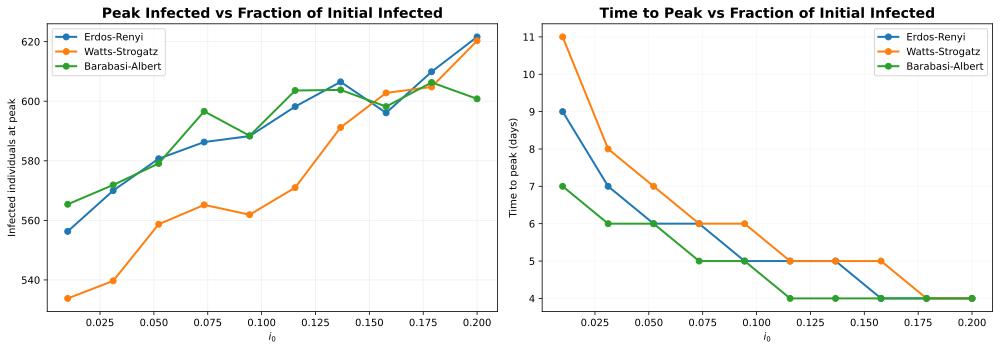

In [43]:
peak_infected = {nt: [] for nt in network_types}
time_to_peak = {nt: [] for nt in network_types}

for nt, results_for_graph in i0_results.items():
    for sim_array in results_for_graph:
        infected = sim_array[:, 1] # column 1 = infected
        peak_infected[nt].append(np.max(infected))
        time_to_peak[nt].append(np.argmax(infected))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].set_title("Peak Infected vs Fraction of Initial Infected", size = 14, fontweight = "bold")
axes[0].set_xlabel("$i_0$")
axes[0].set_ylabel("Infected individuals at peak")
axes[0].grid(alpha=0.2)
axes[1].set_title("Time to Peak vs Fraction of Initial Infected", size = 14, fontweight = "bold")
axes[1].set_xlabel("$i_0$")
axes[1].set_ylabel("Time to peak (days)")
axes[1].grid(alpha=0.1)

for nt in network_types:
    tit, col = tit_col[nt][0], tit_col[nt][1]
    axes[0].plot(i0_values, peak_infected[nt], marker='o', color=col, lw=2, label=tit)
    axes[0].legend()
    axes[1].plot(i0_values, time_to_peak[nt], marker='o', color=col, lw=2, label=tit)
    axes[1].legend()

plt.tight_layout()
plt.show()

In [44]:
# 2. Start from different nodes
# define the nodes to target
def get_top_k_strategic_nodes(graph, k_nodes, centrality_type):
    if centrality_type == 'degree':
        centrality_dict = nx.degree_centrality(graph)
        
    elif centrality_type == 'betweenness':
        centrality_dict = nx.betweenness_centrality(graph)
        
    elif centrality_type == 'closeness':
        centrality_dict = nx.closeness_centrality(graph)
        
    sort_nodes = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    top_k_nodes = [item[0] for item in sort_nodes[:k_nodes]]
    
    return top_k_nodes

In [45]:
k_fixed = 3
targets = ['degree', 'betweenness', 'closeness', 'random'] # random will set i0 = k_fixed / N_sim

targeted_results = {}
for network_type, G in graphs_sim:
    results_for_graph = {}
    print(f"Running targeted infection for {network_type}...")
    for target in targets:
        if target == 'random':
            sim_results = SIR_network_simulate(graph=G, beta=0.1, gamma=0.2, i0=k_fixed / G.number_of_nodes(), time_steps=200, simulations=10)
        else:
            # gets strategic nodes (all type of centrality)
            infected_nodes = get_top_k_strategic_nodes(G, k_fixed, target)
            # simulate results
            sim_results = SIR_network_simulate(graph=G, beta=0.1, gamma=0.2, initial_infected_nodes=infected_nodes, time_steps=200, simulations=10)
        results_for_graph[target] = sim_results.mean(axis=0)
        
    targeted_results[network_type] = results_for_graph

Running targeted infection for erdos_renyi...
Running targeted infection for watts_strogatz...
Running targeted infection for barabasi_albert...



 - Targeting strategy: Degree
Erdos-Renyi | Centrality: peak=230.100 at t=17
Erdos-Renyi | Random: peak=215.300 at t=21
Watts-Strogatz | Centrality: peak=135.500 at t=31
Watts-Strogatz | Random: peak=111.000 at t=30
Barabasi-Albert | Centrality: peak=270.200 at t=9
Barabasi-Albert | Random: peak=278.300 at t=11

 - Targeting strategy: Betweenness
Erdos-Renyi | Centrality: peak=211.100 at t=18
Erdos-Renyi | Random: peak=215.300 at t=21
Watts-Strogatz | Centrality: peak=148.200 at t=29
Watts-Strogatz | Random: peak=111.000 at t=30
Barabasi-Albert | Centrality: peak=291.800 at t=9
Barabasi-Albert | Random: peak=278.300 at t=11

 - Targeting strategy: Closeness
Erdos-Renyi | Centrality: peak=250.000 at t=17
Erdos-Renyi | Random: peak=215.300 at t=21
Watts-Strogatz | Centrality: peak=143.400 at t=25
Watts-Strogatz | Random: peak=111.000 at t=30
Barabasi-Albert | Centrality: peak=285.600 at t=8
Barabasi-Albert | Random: peak=278.300 at t=11


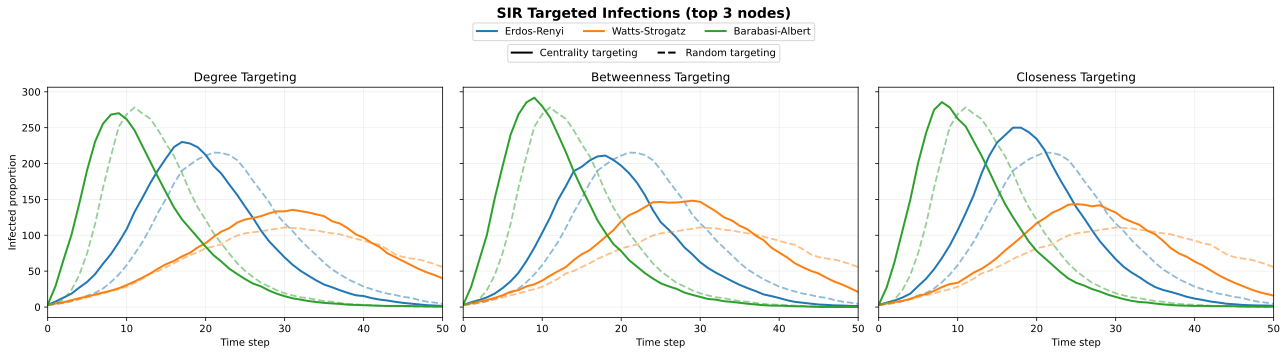

In [46]:
targets = ["degree", "betweenness", "closeness"]
line_styles = {"centrality": "-", "random": "--"} 

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle(f"SIR Targeted Infections (top {k_fixed} nodes)", fontweight = "bold", size = 14)

for ax, target in zip(axes, targets):
    print(f"\n - Targeting strategy: {target.capitalize()}")
    for network_type, results_for_graph in targeted_results.items():
        tit, col = tit_col[network_type][0], tit_col[network_type][1]
        
        # centrality-based infection
        centrality_mean = results_for_graph[target]
        infected_centrality = centrality_mean[:, 1]
        peak_c = infected_centrality.max()
        day_c = infected_centrality.argmax()
        ax.plot(infected_centrality, color=col, linestyle=line_styles["centrality"], lw=2)
        print(f"{tit} | Centrality: peak={peak_c:.3f} at t={day_c}")

        # random infection (baseline)
        random_mean = results_for_graph["random"]
        infected_random = random_mean[:, 1] 
        peak_r = infected_random.max()
        day_r = infected_random.argmax()
        print(f"{tit} | Random: peak={peak_r:.3f} at t={day_r}")
        ax.plot(infected_random, color=col, linestyle=line_styles["random"], lw=1.8, alpha=0.5)

    ax.set_title(f"{target.capitalize()} Targeting")
    ax.set_xlabel("Time step")
    ax.grid(alpha=0.2)
    ax.set_xlim(0, 50)

axes[0].set_ylabel("Infected proportion")
network_handles = [
    plt.Line2D([], [], color=tit_col[nt][1], lw=2, label=tit_col[nt][0])
    for nt in network_types
]
style_handles = [
    plt.Line2D([], [], color="k", lw=2, linestyle=line_styles["centrality"], label="Centrality targeting"),
    plt.Line2D([], [], color="k", lw=2, linestyle=line_styles["random"], label="Random targeting"),
]
fig.legend(handles=network_handles, loc="upper center", ncol=len(network_types), bbox_to_anchor=(0.5, 0.95))
fig.legend(handles=style_handles, loc="upper center", bbox_to_anchor=(0.5, 0.89), ncols = 2)
plt.tight_layout(rect=[0, 0, 1, 0.90])
fig.savefig("targeted_infections.png")
plt.show()


In [47]:
# 3. Change beta values
beta_range = np.linspace(0.1, 0.5, 10)
beta_results = {}
for network_type, G in graphs_sim:
    results_for_graph = []
    print(f"Running beta variation for {network_type}...")
    for beta in beta_range:
        sim_results = SIR_network_simulate(graph=G, beta = beta, gamma = gamma_sim, i0=i0, time_steps=200,simulations=10)
        mean_result = sim_results.mean(axis=0) 
        results_for_graph.append(mean_result)
    beta_results[network_type] = results_for_graph

Running beta variation for erdos_renyi...
Running beta variation for watts_strogatz...
Running beta variation for barabasi_albert...


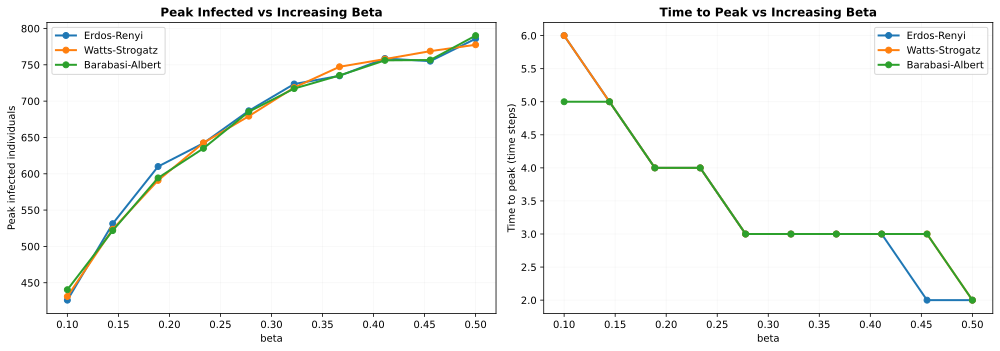

In [48]:
peak_infected_beta = {nt: [] for nt in network_types}
time_to_peak_beta = {nt: [] for nt in network_types}

for idx, (network_type, results_list) in enumerate(beta_results.items()):
    for sim_array in results_list:
        infected = sim_array[:, 1] 
        peak_infected_beta[network_type].append(np.max(infected))
        time_to_peak_beta[network_type].append(np.argmax(infected))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].set_title("Peak Infected vs Increasing Beta", fontweight = "bold")
axes[0].set_xlabel("beta")
axes[0].set_ylabel("Peak infected individuals")
axes[0].grid(alpha=0.1)

axes[1].set_title("Time to Peak vs Increasing Beta", fontweight = "bold")
axes[1].set_xlabel("beta")
axes[1].set_ylabel("Time to peak (time steps)")
axes[1].grid(alpha=0.1)

for nt in network_types:
    tit, col = tit_col[nt][0], tit_col[nt][1]
    axes[0].plot(beta_range, peak_infected_beta[nt], marker='o', color=col, lw=2, label=tit)
    axes[0].legend()
    axes[1].plot(beta_range, time_to_peak_beta[nt], marker='o', color=col, lw=2, label=tit)
    axes[1].legend()

plt.tight_layout()
plt.show()


**2.3** Load Sociopatterns data

In [49]:
data = pd.read_csv("transmission_network.csv", sep=";", index_col=0, dtype=int)
data

FileNotFoundError: [Errno 2] No such file or directory: 'transmission_network.csv'

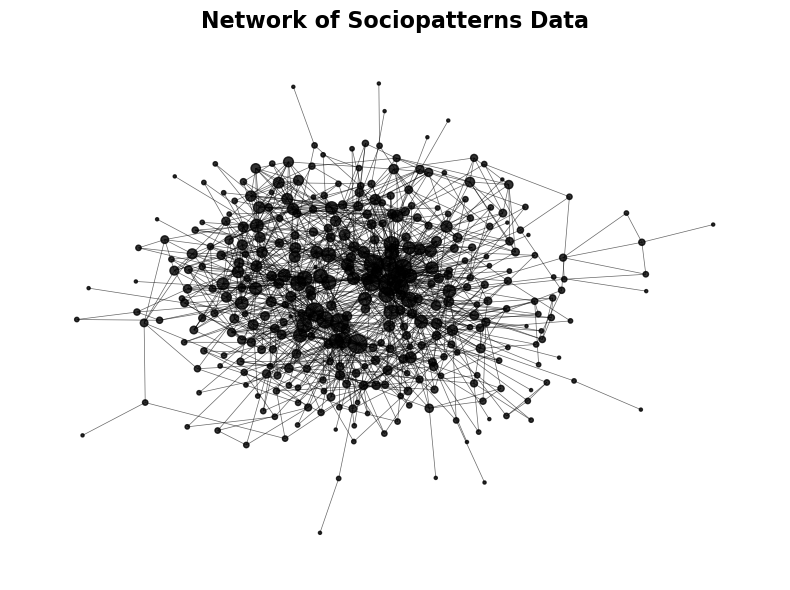

Number of nodes: 374
Number of edges: 1265


In [ ]:
G = nx.Graph()
data.index = data.index.astype(str).str.strip()
data.columns = data.columns.astype(str).str.strip()
G.add_nodes_from(data.index)

for i in range(len(data.index)):
    for j in range(i+1, len(data.columns)): # only process above diagonal
        if data.iloc[i,j] > 0: 
            G.add_edge(data.index[i], data.columns[j])

plt.figure(figsize=(8,6))

degree = dict(G.degree())
node_sizes = [degree[node] * 5 for node in G.nodes()]

pos = nx.kamada_kawai_layout(G, scale=0.2)
nx.draw_networkx_edges(G, pos, alpha=0.6, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='black', alpha=0.8)

plt.title("Network of Sociopatterns Data", fontsize=16, fontweight='bold')
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

First, we briefly analyze the network's structural characteristics.

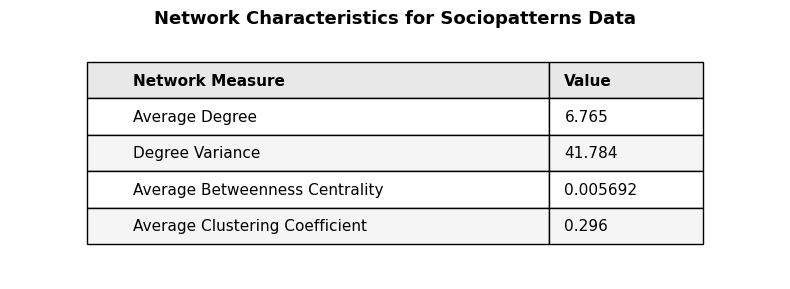

In [ ]:
degrees = [d for n, d in G.degree()]
metrics_data = {
    'Network Measure': ['Average Degree', 'Degree Variance', 'Average Betweenness Centrality', 'Average Clustering Coefficient'],
    'Value': [
        f'{np.mean(degrees):.3f}',
        f'{np.var(degrees):.3f}',
        f'{np.mean(list(nx.betweenness_centrality(G).values())):.6f}',
        f'{nx.average_clustering(G):.3f}']
}

df_metrics = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
table = ax.table(cellText=df_metrics.values, colLabels=df_metrics.columns, 
                cellLoc='left', loc='center', colWidths=[0.6, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

for i in range(2):
    table[(0, i)].set_facecolor('#E8E8E8')
    table[(0, i)].set_text_props(weight='bold', ha='left')

for i in range(1, 5):
    for j in range(2):
        table[(i, j)].set_facecolor('#F5F5F5' if i % 2 == 0 else 'white')

plt.title('Network Characteristics for Sociopatterns Data', fontsize=13, fontweight='bold', pad=1)
plt.tight_layout()
plt.show()

The high variance indicates the network might resemble a Barabasi-Albert type.

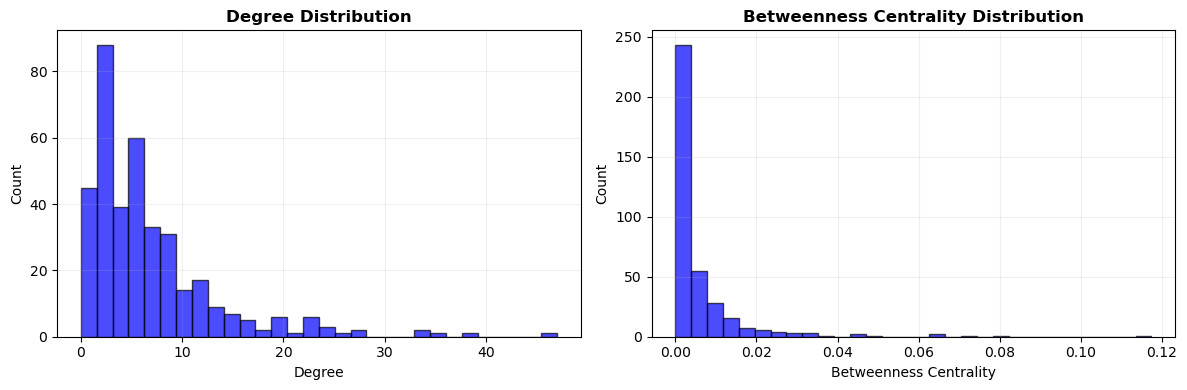

In [ ]:
betweenness = nx.betweenness_centrality(G)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(degrees, bins=30, color = 'blue',edgecolor='black', alpha=0.7)
ax1.set_xlabel("Degree")
ax1.set_ylabel("Count")
ax1.set_title("Degree Distribution", fontweight = 'bold')
ax1.grid(alpha=0.2)

ax2.hist(list(betweenness.values()), color = 'blue',bins=30, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Betweenness Centrality')
ax2.set_ylabel('Count')
ax2.set_title('Betweenness Centrality Distribution', fontweight='bold')
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()

The degree distribution follows a power law, which is characteristic for Barabasi-Albert graph. Betweenness centrality distribution also follows a power-law distribtion, again characteristic for the Barabsi-Albert network.

**2.4** Run simulations of the SIR on the network and test 2 vaccination strategies (null and degree-dependent) with various values of vaccination and testing budget and test accuracy.

In [ ]:
def SIR_model(G, beta, gamma):
    model = ep.SIRModel(G)
    config = mc.Configuration()
    config.add_model_parameter("beta", beta)
    config.add_model_parameter("gamma", gamma)
    config.add_model_parameter("fraction_infected", 5/374)
    model.set_initial_status(config)
    return model 

In [ ]:
def test(node, model, test_accuracy): 
    status = model.status[node]
    if status == 0: 
        return 0 if np.random.rand() < test_accuracy else 1
    elif status == 1: 
        return 1 if np.random.rand() < test_accuracy else 0
    else:
        return 2

In [ ]:
def null_simulation(G, model, num_timesteps, vaccination_budget): 
    S, I, R = [], [], []

    for t in range(num_timesteps):
        nodes = np.random.choice(list(G.nodes), size = vaccination_budget)
        for node in nodes: 
            model.status[node] = 2
        
        model.iteration()

        statuses = list(model.status.values())
        n = len(statuses)
        S.append(statuses.count(0))
        I.append(statuses.count(1))
        R.append(statuses.count(2))
    
    return S, I, R

In [ ]:
def degree_simulation(G, model, num_timesteps, test_accuracy, tests_budget, tests_per_iteration, vaccination_budget):
    degree_S, degree_I, degree_R = [], [], []

    degrees = dict(G.degree)
    sorted_nodes = sorted(degrees, key = degrees.get, reverse=True)

    tests_so_far = 0

    start = 0 
    end = tests_per_iteration

    for t in range(num_timesteps): 
        if tests_so_far >= tests_budget: 
            break 

        nodes_to_test = sorted_nodes[start:end]

        vaccinated = 0

        for node in nodes_to_test:
            if vaccinated >= vaccination_budget:
                break 

            test_result = test(node, model, test_accuracy)
            if test_result == 0: 
                model.status[node] = 2
                vaccinated += 1
        
        model.iteration()

        statuses = list(model.status.values())
        n = len(statuses)
        degree_S.append(statuses.count(0))
        degree_I.append(statuses.count(1))
        degree_R.append(statuses.count(2))

        start += tests_per_iteration
        end += tests_per_iteration
        tests_so_far += tests_per_iteration
    
    return degree_S, degree_I, degree_R

In [ ]:
vaccination_budget = [1, 3, 5, 10]
tests_budget = 420 
tests_per_iteration = [3,5,7,12]
test_accuracy = [0.5, 0.75, 1.0]

results = {}

for acc in test_accuracy:
    results[acc] = {}
    for vacc_budget, test_per_iter in zip(vaccination_budget, tests_per_iteration):
        print(f"Running: accuracy={acc}, vacc_budget={vacc_budget}, test_iter={test_per_iter}")

        num_timesteps = int(tests_budget / test_per_iter)

        model_null = SIR_model(G, beta=0.03, gamma=0.01)
        model_deg = SIR_model(G, beta=0.03, gamma=0.01)

        S_null, I_null, R_null = null_simulation(G, model_null, num_timesteps, vacc_budget)
        S_deg, I_deg, R_deg = degree_simulation(G, model_deg, num_timesteps, acc, tests_budget, test_per_iter, vacc_budget)

        results[acc][(vacc_budget, test_per_iter)] = {
            "S_null": S_null, "I_null": I_null, "R_null": R_null,
            "S_deg": S_deg, "I_deg": I_deg, "R_deg": R_deg
        }

Running: accuracy=0.5, vacc_budget=1, test_iter=3
Running: accuracy=0.5, vacc_budget=3, test_iter=5
Running: accuracy=0.5, vacc_budget=5, test_iter=7
Running: accuracy=0.5, vacc_budget=10, test_iter=12
Running: accuracy=0.75, vacc_budget=1, test_iter=3
Running: accuracy=0.75, vacc_budget=3, test_iter=5
Running: accuracy=0.75, vacc_budget=5, test_iter=7
Running: accuracy=0.75, vacc_budget=10, test_iter=12
Running: accuracy=1.0, vacc_budget=1, test_iter=3
Running: accuracy=1.0, vacc_budget=3, test_iter=5
Running: accuracy=1.0, vacc_budget=5, test_iter=7
Running: accuracy=1.0, vacc_budget=10, test_iter=12


In [ ]:
def plot_results_grid(results):
    n_acc = len(results)
    fig, axes = plt.subplots(n_acc, 4, figsize=(20, 4*n_acc), sharey=True)
    fig.suptitle("SIR results comparison", fontsize=18, fontweight='bold', y=0.98)

    for row_idx, (acc, setups) in enumerate(results.items()):
        sorted_setups = sorted(setups.items(), key=lambda x: x[0][0])
        for col_idx, ((vacc_budget, test_iter), vals) in enumerate(sorted_setups):
            timesteps = np.arange(len(vals["S_deg"]))
            ax = axes[row_idx, col_idx] if n_acc > 1 else axes[col_idx]

            ax.plot(timesteps, vals["S_null"], '--', label='S (Null)', alpha=1.0, color='#5DADE2')   
            ax.plot(timesteps, vals["I_null"], '--', label='I (Null)', alpha=1.0, color='blue', lw=2)  
            ax.plot(timesteps, vals["R_null"], '--', label='R (Null)', alpha=0.8, color='#2471A3')   

            ax.plot(timesteps, vals["S_deg"], label='S (Degree)', alpha=0.8, color='#F1948A')        
            ax.plot(timesteps, vals["I_deg"], label='I (Degree)', alpha=1.0, color='#e60000', lw=2)  
            ax.plot(timesteps, vals["R_deg"], label='R (Degree)', alpha=0.8, color='#E74C3C')

            if col_idx == 0:
                ax.set_ylabel("Number of people")
                ax.text(-0.25, 0.5, f"Test Accuracy = {acc}", transform=ax.transAxes,
                        fontsize=12, fontweight='bold', va='center', rotation=90)
            if row_idx == n_acc - 1:
                ax.set_xlabel("Timestep")
            ax.set_title(f"Vacc={vacc_budget}, Tests/Iter={test_iter}")
            ax.grid(True, alpha=0.3)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=10, ncol=6)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

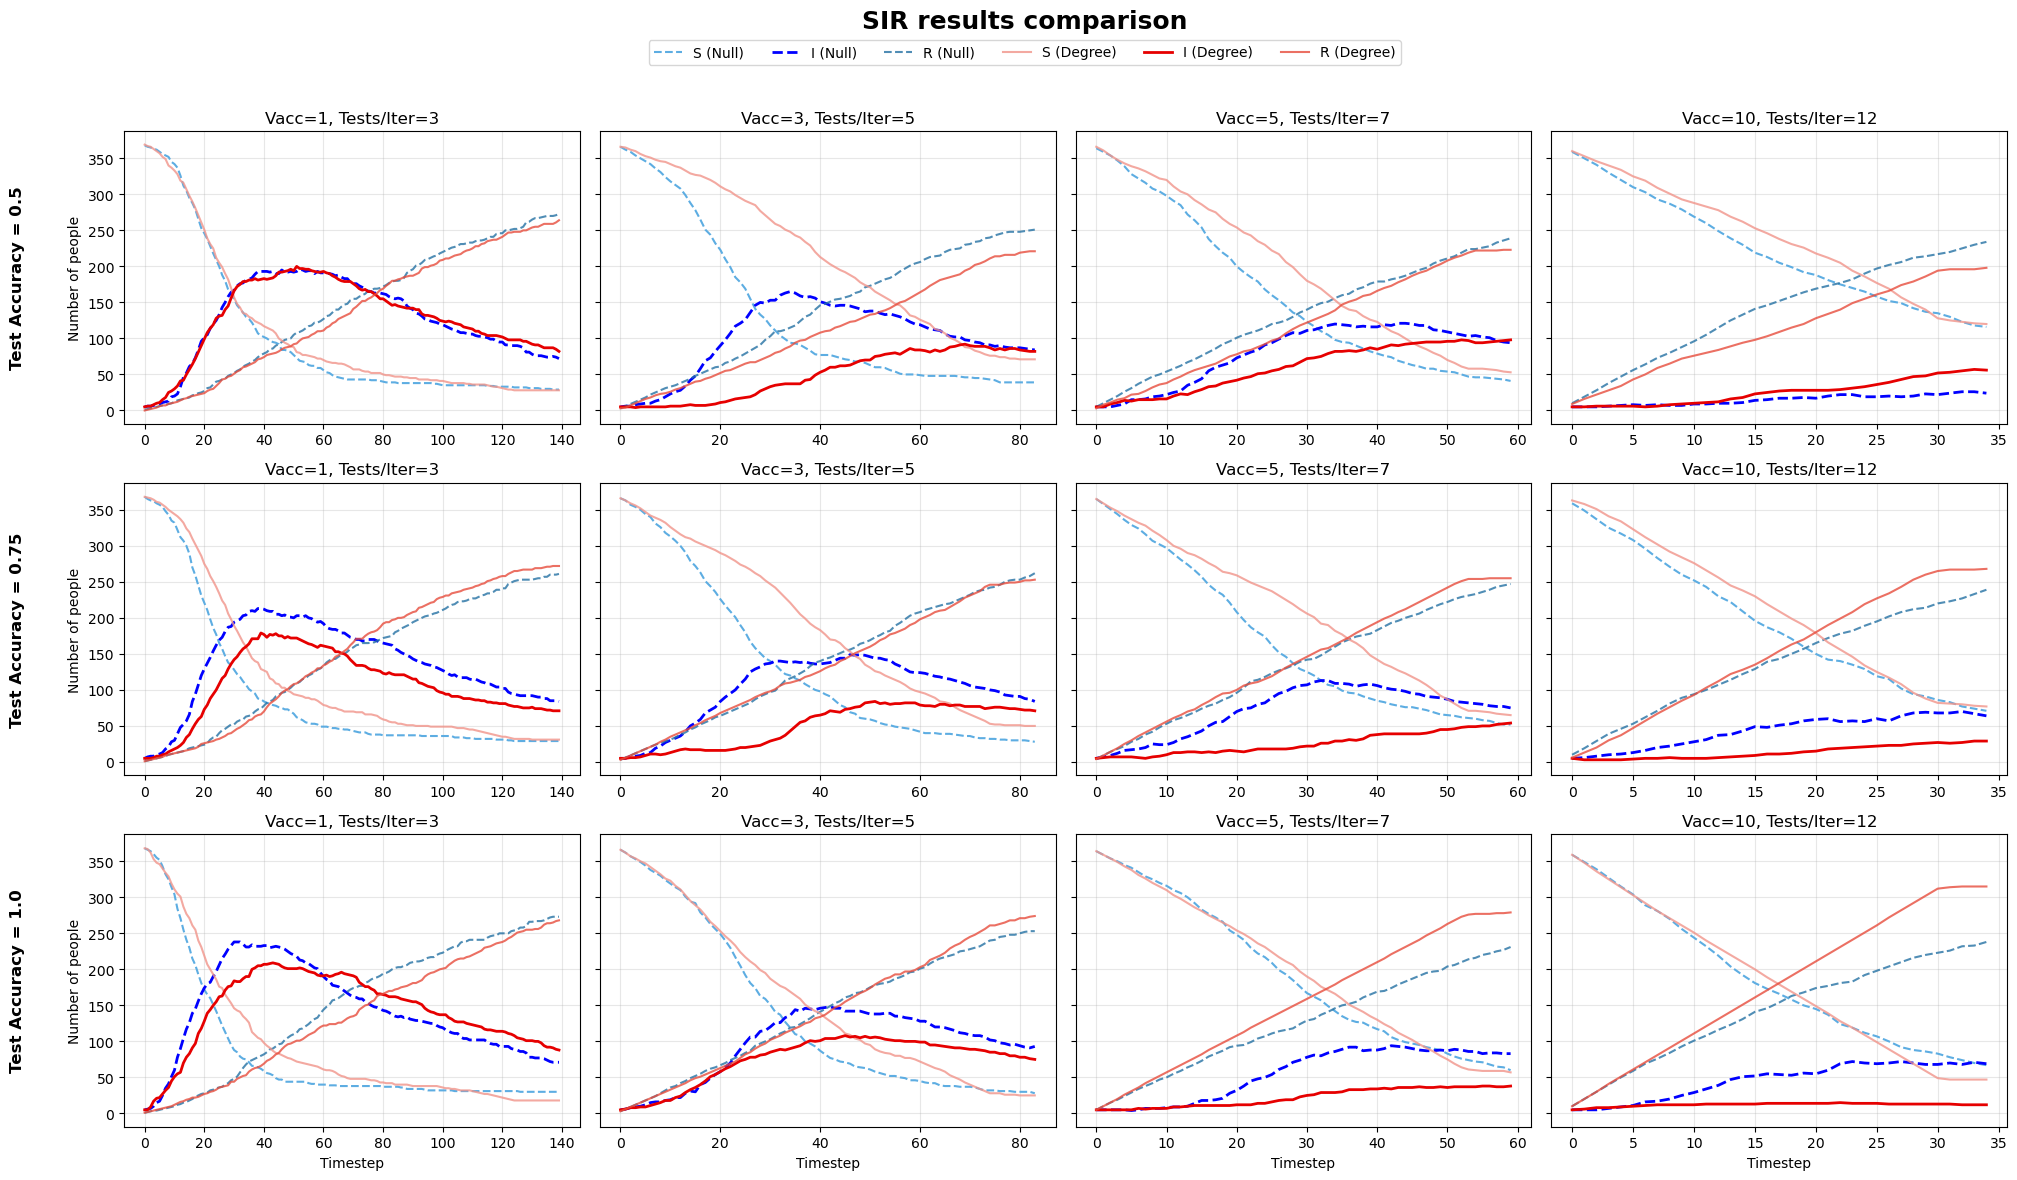

In [ ]:
plot_results_grid(results)

Degree strategy outperforms the null strategy in cases where infected (purple) is below the orange curve (infected for null).